#### This notebook examine limitations on diatom growth, especially in the Southern Ocean, with the goal of decreasing the positive silicate bias in the Southern Ocean in CESM2

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
from glob import glob
from collections import OrderedDict
import xarray as xr
import numpy as np
import esmlab
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from scipy import stats
import pop_tools 
from statistics import mean
from matplotlib import style
from scipy import stats
#style.use('ggplot')

import matplotlib.colors as colors

In [8]:
case = 'g.e21.G1850ECOIAF.T62_g16.004'
path = '/glade/scratch/kristenk/archive/' + case + '/ocn/proc/tseries/month_1'
variables = ['diat_Fe_lim_surf', 'diat_P_lim_surf','diat_N_lim_surf','diat_SiO3_lim_surf','photoC_TOT_zint',
             'diat_light_lim_Cweight_avg_100m',
             'diat_light_lim_surf','diat_Fe_lim_Cweight_avg_100m',
             'SiO3','NO3', 'PO4'] 
coords = {'x':'TLONG','y':'TLAT'}

In [9]:
keepthese = ['z_t','z_t_150m','time_bound','TAREA','REGION_MASK', 'time'] + variables

In [10]:
%%time

ds_list = []
print(f'reading {case}')
ds = xr.Dataset()
for v in variables:
    
    print(v)
    
    files = sorted(glob(f'{path}/{case}.pop.h.{v}.??????-??????.nc'))     
    
    dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"], decode_times=True)

    ds = xr.merge((ds, dsv))
    ds_list.append(ds)

reading g.e21.G1850ECOIAF.T62_g16.004
sp_Fe_lim_surf
sp_P_lim_surf
sp_N_lim_surf
diat_Fe_lim_surf
diat_P_lim_surf
diat_N_lim_surf
diat_SiO3_lim_surf
photoC_TOT_zint
photoC_sp_zint
photoC_diat_zint
photoC_diaz_zint
diat_light_lim_Cweight_avg_100m
diat_light_lim_surf
diat_Fe_lim_Cweight_avg_100m
SiO3
NO3
PO4
CPU times: user 10.6 s, sys: 521 ms, total: 11.2 s
Wall time: 15.3 s


In [11]:
keep_vars = keepthese +list(coords.values())+['dz','KMT']
ds = ds.drop([v for v in ds.variables if v not in keep_vars])

In [13]:
tlen=len(ds.time)
#resetting the time variable so that it's a mean of the time bounds
ds["time"] = ds.time_bound.compute().mean(dim="d2")

In [14]:
ds_annmean = xr.Dataset()
for v in variables:
    ds_annmean[v] = ds[v].isel(time=slice(-120,tlen)).mean(dim='time')

In [15]:
#just getting this for the coords (that don't have nans)
file = '/glade/work/kristenk/WOA_data/regrid_POP/WOA2018_POPgrid.nc'
ds_woa = xr.load_dataset(file, decode_times=False, decode_coords=False)
z_t = ds.z_t
lons=ds_woa.TLONG
lats=ds_woa.TLAT
area=ds_woa.TAREA
depths=ds_woa.z_t * 0.01

In [21]:
limarray_diat_surf=xr.concat((ds_annmean.diat_P_lim_surf, ds_annmean.diat_Fe_lim_surf, ds_annmean.diat_N_lim_surf, ds_annmean.diat_SiO3_lim_surf),dim='nutrient')
most_lim_diat=limarray_diat.argmin(dim='nutrient', skipna=False)
most_lim_diat = most_lim_diat.squeeze()
mask = np.isnan(ds_annmean.diat_N_lim_surf.squeeze())

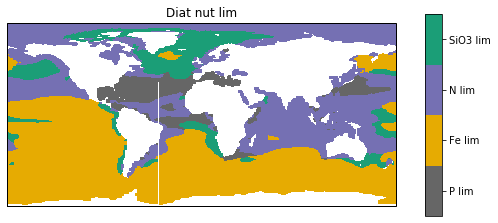

In [28]:
fig = plt.figure(figsize=(8,4))

ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
ax.set_title('Diat nut lim', fontsize=12)
pc=ax.pcolormesh(lons, lats, most_lim_diat.where(~mask), cmap=plt.cm.get_cmap('Dark2_r',4),vmin=-0.5,vmax=3.5)
colorbar_specs = {'ticks' : np.arange(0,4,1)}
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.03, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax,**colorbar_specs)
cbar.ax.set_yticklabels(['P lim', 'Fe lim', 'N lim','SiO3 lim']);

In [31]:
ds_woa['z_t'] = ds.z_t
SiO3_diff = ds_annmean.SiO3 - ds_woa.SiO3

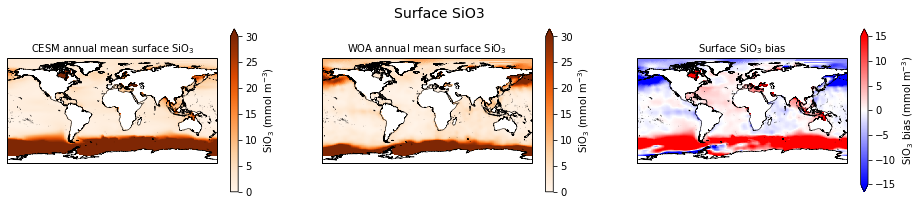

In [35]:
fig = plt.figure(figsize=(16,3))
plt.suptitle('Surface SiO3', fontsize=14)

####################SiO3
#---- CESM panel
ax = fig.add_subplot(1,3,1, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('CESM annual mean surface SiO$_3$', fontsize=10)
pc1=ax.pcolormesh(lons, lats, 
                 ds_annmean.SiO3.isel(z_t=0), 
                  vmin=0, vmax=30, 
                  cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='SiO$_3$ (mmol m$^{-3}$)')

#---- OBS panel
ax = fig.add_subplot(1,3,2, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('WOA annual mean surface SiO$_3$', fontsize=10)
pc2=ax.pcolormesh(lons, lats, 
                 ds_woa.SiO3.isel(z_t=0), 
                  vmin=0, vmax=30, 
                  cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc2, ax=ax,extend='max',label='SiO$_3$ (mmol m$^{-3}$)')

#---- DIFF panel
ax = fig.add_subplot(1,3,3, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('Surface SiO$_3$ bias', fontsize=10)
pc3=ax.pcolormesh(lons, lats, 
                 SiO3_diff.isel(z_t=0), 
                  vmin=-15, vmax=15, 
                  cmap='bwr',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc3, ax=ax,extend='both',label='SiO$_3$ bias (mmol m$^{-3}$)')

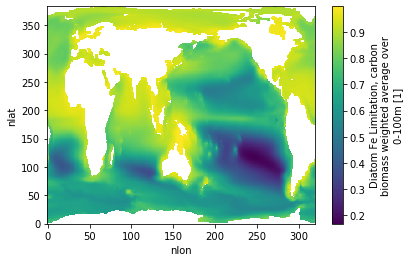

In [37]:
ds_annmean.diat_Fe_lim_Cweight_avg_100m.plot()

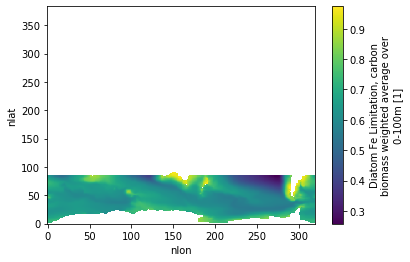

In [40]:
ds_annmean.diat_Fe_lim_Cweight_avg_100m.where(ds.REGION_MASK==1).plot()

In [52]:
diat_Fe_lim_100m_SOc=esmlab.weighted_mean(ds_annmean['diat_Fe_lim_Cweight_avg_100m'].where(ds.REGION_MASK==1), weights=ds.TAREA, dim=['nlat', 'nlon']).compute()
diat_Fe_lim_surf_SOc=esmlab.weighted_mean(ds_annmean['diat_Fe_lim_surf'].where(ds.REGION_MASK==1), weights=ds.TAREA, dim=['nlat', 'nlon']).compute()
print('Diatom Fe lim at surface in Southern Ocean is',diat_Fe_lim_surf_SOc.values)
print('Diatom Fe lim over 100m in Southern Ocean is',diat_Fe_lim_100m_SOc.values)

Diatom Fe lim at surface in Southern Ocean is 0.5926433899378842
Diatom Fe lim over 100m in Southern Ocean is 0.6345042762542052


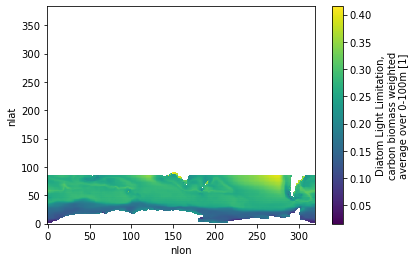

In [48]:
ds_annmean.diat_light_lim_Cweight_avg_100m.where(ds.REGION_MASK==1).plot()

In [49]:
diat_light_lim_100m_SOc=esmlab.weighted_mean(ds_annmean['diat_light_lim_Cweight_avg_100m'].where(ds.REGION_MASK==1), weights=ds.TAREA, dim=['nlat', 'nlon']).compute()
diat_light_lim_surf_SOc=esmlab.weighted_mean(ds_annmean['diat_light_lim_surf'].where(ds.REGION_MASK==1), weights=ds.TAREA, dim=['nlat', 'nlon']).compute()
print('Diatom light lim at surface in Southern Ocean is',diat_light_lim_surf_SOc.values,'.')
print('Diatom light lim over 100m in Southern Ocean is',diat_light_lim_100m_SOc.values,'.')

diatom light lim at surface in Southern Ocean is 0.4201742412187731 .
diatom light lim over 100m in Southern Ocean is 0.25713535245753893 .
